# Computer Vision Workflow

## Developing a Process

Our approach ...

* Read image
* Crop
* Separate into channels
* Creat a composite
* Equalize histogram
* Blur/Low Pass Filter
* Segment/Threshold
* Use Morphology Transforms to isolate objects
* Locate Objects - Blobs vs Hough Transforms
* Prepare a Report

### Python Imports

We track overall code dependencies by consolidating imports into this cell. Note that we'll be using elements from multiple packages by relying on the underlying NumPy representation of images to hold the current state of the process.

In [17]:
!pip install opencv-python --upgrade

In [18]:
# standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

# computer vision libraries
import cv2 as cv2

### Reading images

As a first step, read the image, convert to rgb scale, and display. All of these packages have a means of reading raster file images in common formats. There are small (and sometimes frustrating) differences among them. Here we use the Matplotlib ``imread()`` method which reads and returns a numpy array.

The array will typical have 2 or 3 dimensions $(h, w, d)$ where $h$ and $w$ are image height and width, and $d$ is pixel depth.

* If $d$ is one or not present, it is a gray scale image
* If $d$ is 3, then typically it is an RGB image with the channels repesenting R, G, and B colors. Note that OpenCV orders the channels as BGR.
* If $d$ is 4, the image could be RGBA where A refers to an alpha transparency channel, or a CYMK encoded color image.

In [23]:
path = "image_data/"
file = "25-miniM.tif"

path = "image_data/Jiang Photos/"
file = "Gold STEM HAADF 59000 x 20220318 1542.tif"

# read color image with OpenCV
img_bgr = cv2.imread(path + file)
print(img.shape)

(2048, 2048, 3)


Text(0.5, 1.0, 'A BGR image incorrectly shown as RGB')

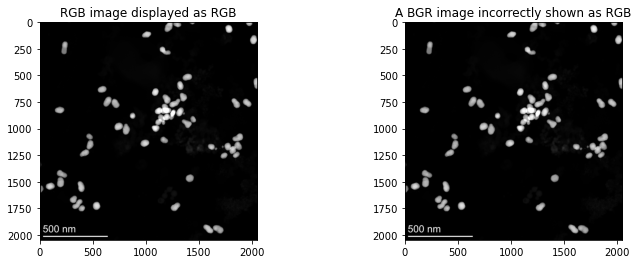

In [24]:
# convert to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# display images with Matploblib
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].imshow(img_rgb)
ax[0].set_title("RGB image displayed as RGB")

ax[1].imshow(img_bgr)
ax[1].set_title("A BGR image incorrectly shown as RGB")

Observations:

* There are extraneous elements at the edges of the image

### Cropping

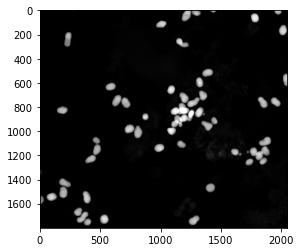

In [25]:
img = img_rgb[0:1800, :, :].copy()
plt.imshow(img)

### Channels and Histograms

An image is comprised of one or more channels

* Each channel can be treated as a gray scale image
* The values at each pixel may be
    * An 8-bit unsigned integer in the range 0 to 255 (most common)
    * A 12, 14, or 16 bit unsigned integer
    * A real number between 0 and 1
* Color must always be interpreted with respect to [color space](https://en.wikipedia.org/wiki/Color_space).
    


In [26]:
r, g, b = cv2.split(img)

Histograms are a tool for analyzing the distribution of gray levels in a channel. It's a powerful tool for controlling exposure and processing images for presentation.

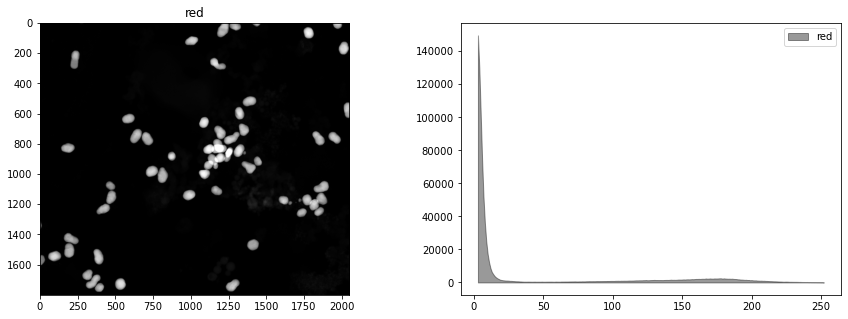

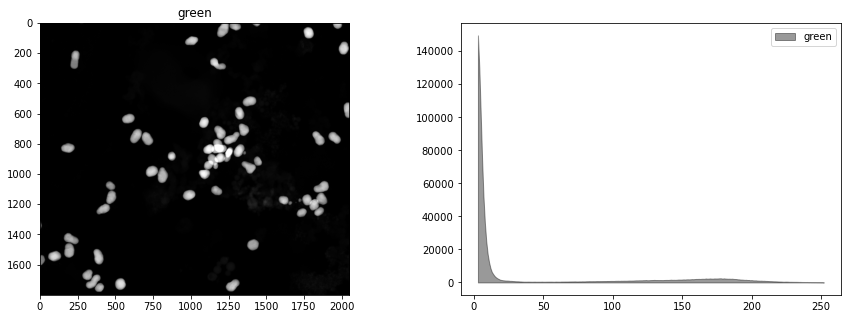

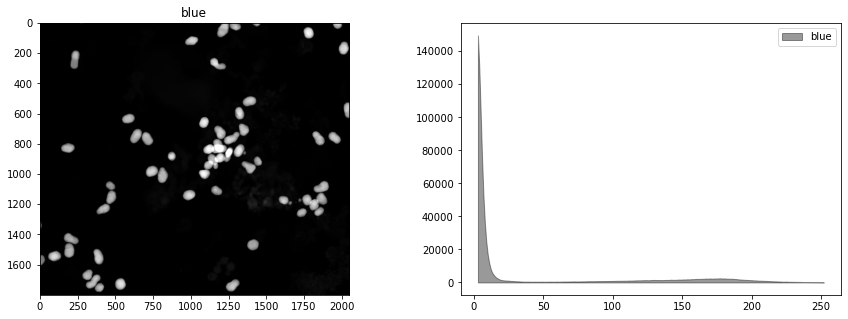

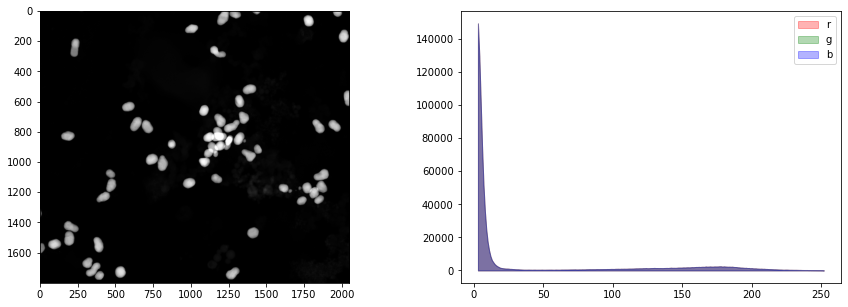

In [30]:
def histogram(channel, bp=3, wp=252):
    """Return histogram and bins for a single channel."""
    hist = cv2.calcHist([channel], [0], None, [wp-bp+1], [bp, wp])
    bins = np.array([b for b in range(bp, wp+1)])
    return hist.flatten(), bins

def display_channel(channel, label=""):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(channel.astype(np.uint8), cmap="gray")
    ax[0].set_title(label)
    hist, bins = histogram(channel.astype(np.uint8))
    ax[1].fill_between(bins, hist, alpha=0.4, color="k", label=label)
    ax[1].legend()

display_channel(r, "red")
display_channel(g, "green")
display_channel(b, "blue")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img)
for color, channel in zip(['r', 'g', 'b'], [r, g, b]):
    hist, bins = histogram(channel)
    ax[1].fill_between(bins, hist, color=color, label=color, alpha=0.3)
ax[1].legend()

### Creating a composite channel

This image shows very little difference among the color channels. 

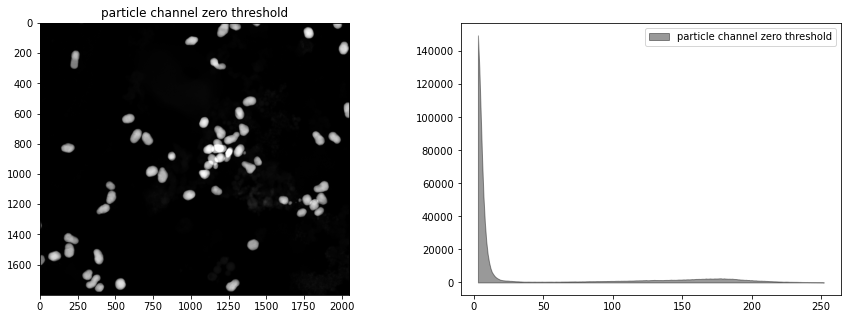

In [33]:
# subtract blue channel from green channel
blue_weight = 0.58
offset = -20
cimg = (0.33*r + 0.34*g + 0.33*b)

# convert to integer
cimg = cimg.astype(np.uint8)
display_channel(cimg, "particle channel zero threshold")

### Histogram equalization

At this stage our composite image appears significantly underexposed. Looking at just the green channel, increasing the exposure 4x, or even 6x, would significantly brighten the particles that we're seeking to detect. In future versions of the experiment it may be useful to experiment with signficantly brighter lenses, light sources, or longer exposures.

In the meanwhile, the step in image processing is to equalize the histogram to improve opportunities for effective particle detection.

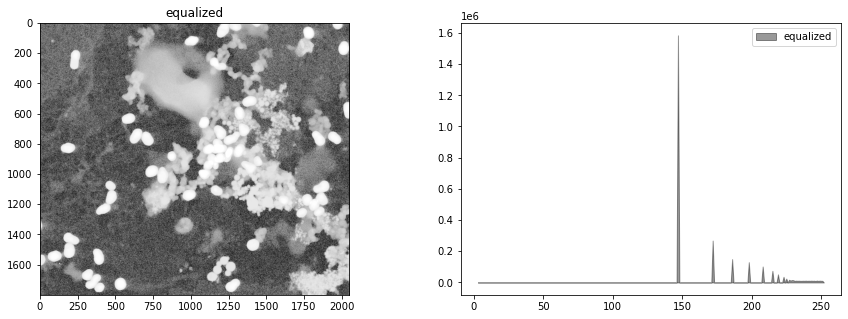

In [66]:
himg = cv2.equalizeHist(cimg)
display_channel(himg, 'equalized')

Observations

* Quantization (sometimes seen as banding) caused by limited number of levels in the channel.
* The image was underexposed at the time of capture.
* There is significant and probably irrelevant information buried in the dark tones. 

### Blur filter


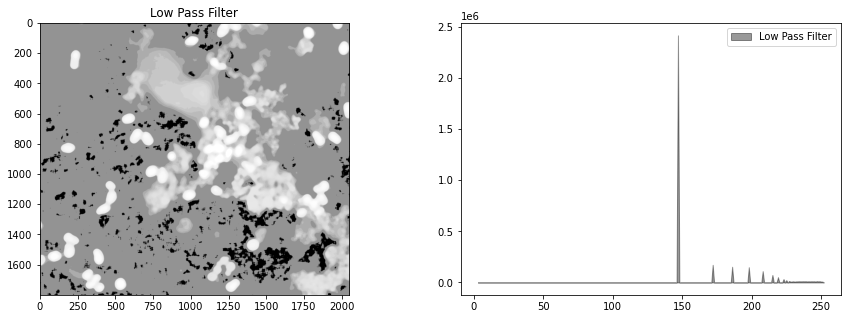

In [67]:
# kernel size (odd number)
ksize = 21

# median filter
bimg = cv2.medianBlur(himg, ksize)
display_channel(bimg, "Low Pass Filter")

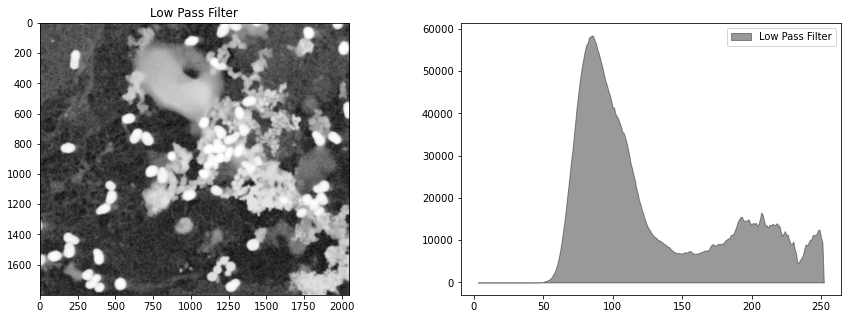

In [68]:
# Gaussian filter
bimg = cv2.GaussianBlur(himg, (ksize, ksize), 0)
display_channel(bimg, "Low Pass Filter")

### Thresholding/Segmentation

The purpose of threshold is to isolate the features of interest from background noise. 

https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html

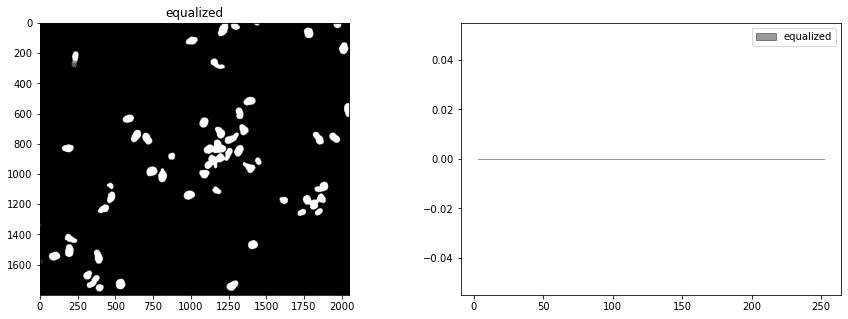

In [69]:
ret, timg = cv2.threshold(cimg, 128, 255, cv2.THRESH_BINARY)
display_channel(timg, 'equalized')

Threshold = 0.0


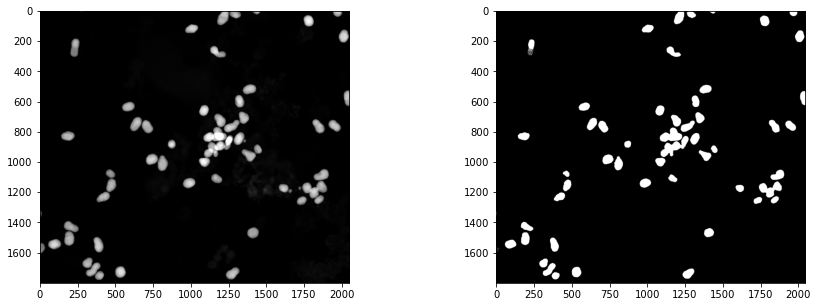

In [70]:
threshold = 130

T, simg = cv2.threshold(timg, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(simg, cmap="gray")
print(f"Threshold = {T}")

### Morphological Transformation

The next goal is to remove noise and to separate particles.

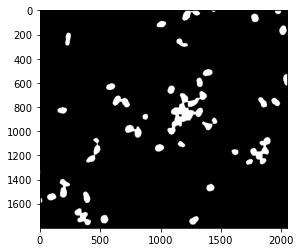

In [71]:
kernel = np.ones((3, 3))
iterations = 8

def morph_close (img, kernel, iterations=1):
    ret = cv2.dilate(img, kernel=kernel, iterations=iterations)
    ret = cv2.erode(ret, kernel=kernel, iterations=iterations)
    return ret

close_img = morph_close(simg, kernel, iterations)
plt.imshow(close_img, cmap="gray")

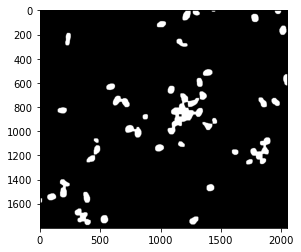

In [72]:
kernel = np.ones((3, 3))
iterations = 8

def morph_open(img, kernel, iterations):
    ret = cv2.erode(img, kernel=kernel, iterations=iterations)
    ret = cv2.dilate(ret, kernel=kernel, iterations=iterations)
    return ret

open_img = morph_open(close_img, kernel, iterations)

plt.imshow(open_img, cmap="gray")

### Finding Objects

http://pageperso.lif.univ-mrs.fr/~francois.denis/IAAM1/scipy-html-1.0.0/tutorial/ndimage.html

/var/folders/cm/z3t28j296f98jdp1vqyplkz00000gn/T/ipykernel_11775/3620703114.py:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  label_img, particle_count = ndimage.measurements.label(open_img, structure=structure)


Text(0.5, 1.0, '40 particles labeled')

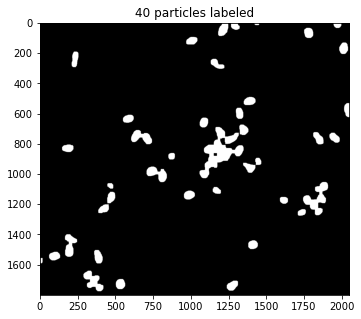

In [56]:
# find particles and plot objects
structure = np.ones((3, 3))
label_img, particle_count = ndimage.measurements.label(open_img, structure=structure)

# pixels are labeled with numbers corresponding to objects
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.imshow(np.where(label_img > 0, 1, np.zeros(label_img.shape)), cmap="gray")
ax.set_title(f"{particle_count} particles labeled")

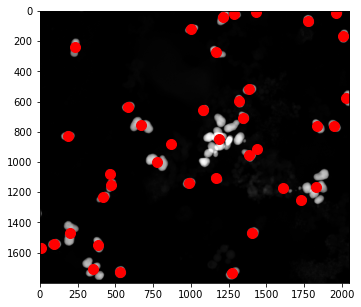

In [57]:
# centers of mass
pts = ndimage.center_of_mass(open_img, label_img, np.arange(1, particle_count + 1))

x = [x for (y,x) in pts]
y = [y for (y,x) in pts]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.imshow(img)
ax.plot(x, y, '.', ms=20, color='r')

### Finding and Displaying Particles

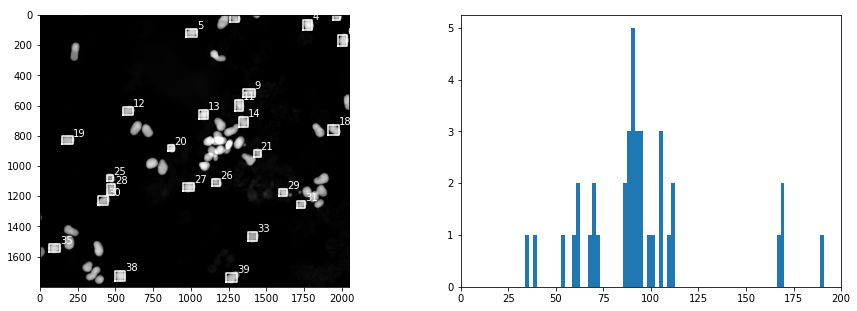

In [58]:
# find the objects and place bounding boxes
slices = ndimage.find_objects(label_img)
sizes = [np.sqrt((b.stop-b.start)**2 + (a.stop-a.start)**2) for a,b in slices]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[1].hist(sizes, bins=200)
ax[1].set_xlim(0, 200)
ax[0].imshow(img)
for k,size in enumerate(sizes):
    if size > 50 and size < 100:
        a,b = slices[k]
        ya = a.start
        yb = a.stop
        xa = b.start
        xb = b.stop
        ax[0].plot([xa, xb, xb, xa, xa], [yb, yb, ya, ya, yb], 'w')
        ax[0].text(xb, ya, f"{k}", color="w")

### Creating a Training Set

/var/folders/cm/z3t28j296f98jdp1vqyplkz00000gn/T/ipykernel_11775/1243267172.py:16: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax[i].imshow(open_img[round_slice(a, 100), round_slice(b, 100)])


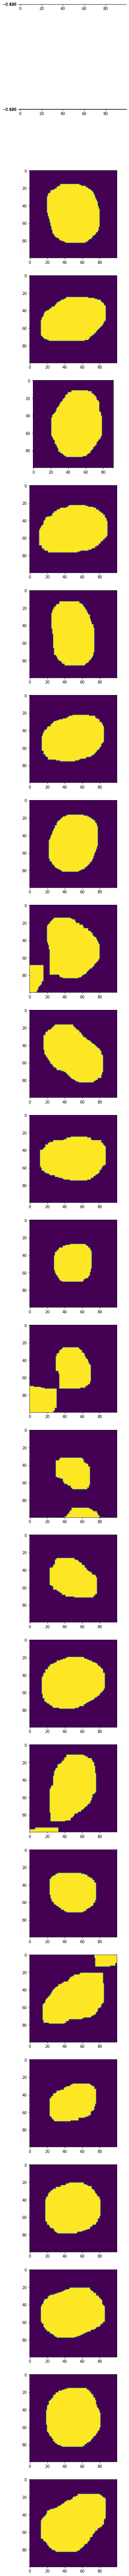

In [59]:
kdx = [k for k, size in enumerate(sizes) if size > 50 and size < 100]

dx = 100
dy = 100

def round_slice(s, n):
    """Round up slice to be width n"""
    m = s.stop - s.start
    start = s.start - int((n - m)/2)
    stop = start + n
    return slice(start, stop, 1)

fig, ax = plt.subplots(len(kdx), 1, figsize=(5, 5*len(kdx)))
for i, k in enumerate(kdx):
    a, b = slices[k]
    ax[i].imshow(open_img[round_slice(a, 100), round_slice(b, 100)])

### What did we learn about our application?

* Improved Image Capture
    * Reduce glare from the blue leds
    * Increase exposure
    
* Image Processing Steps
    * read image
    * 
    * separate channels
    * combine channels to isolate green flourescent particles (weights?)
    * median filtering (size?)
    * histogram equalization
    * threshold (threshold value?)
    * morphological opening (kernal?, iterations?)
    * labeling (size?)
    